In [31]:
# --- Needed Libraries ---
import torch
import torch.nn as nn
import numpy as np
from skimage import measure # For marching cubes
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math # For pi
# --- Configuration ---
# Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [32]:
# --- 1. Define the Surface (Cheese-like) ---
# Functions fd_cheese_numpy, fd_cheese_torch, bbox, grad_fd, hessian_fd
# (Copied directly from the notebook/previous code)
def fd_cheese_numpy(p):
    # Ensure input is a NumPy array for calculation
    if isinstance(p, torch.Tensor):
        p = p.cpu().numpy()
    x, y, z = p[:, 0], p[:, 1], p[:, 2]
    term1 = (4 * x**2 - 1)**2
    term2 = (4 * y**2 - 1)**2
    term3 = (4 * z**2 - 1)**2
    term4 = 16 * (x**2 + y**2 - 1)**2
    term5 = 16 * (x**2 + z**2 - 1)**2
    term6 = 16 * (y**2 + z**2 - 1)**2
    return term1 + term2 + term3 + term4 + term5 + term6 - 16

def fd_cheese_torch(p_tensor):
    x, y, z = p_tensor[:, 0], p_tensor[:, 1], p_tensor[:, 2]
    term1 = (4 * x**2 - 1)**2
    term2 = (4 * y**2 - 1)**2
    term3 = (4 * z**2 - 1)**2
    term4 = 16 * (x**2 + y**2 - 1)**2
    term5 = 16 * (x**2 + z**2 - 1)**2
    term6 = 16 * (y**2 + z**2 - 1)**2
    return term1 + term2 + term3 + term4 + term5 + term6 - 16

bbox = np.array([[-1.5, 1.5], [-1.5, 1.5], [-1.5, 1.5]])

def grad_fd(p_tensor):
    p_tensor_req_grad = p_tensor.detach().clone().requires_grad_(True)
    psi_val = fd_cheese_torch(p_tensor_req_grad)
    grad_psi = torch.autograd.grad(psi_val.sum(), p_tensor_req_grad, create_graph=False)[0]
    return grad_psi.detach()

def hessian_fd(p_tensor):
    p_tensor_req_grad = p_tensor.detach().clone().requires_grad_(True)
    psi_val = fd_cheese_torch(p_tensor_req_grad)
    grad_psi = torch.autograd.grad(psi_val.sum(), p_tensor_req_grad, create_graph=True)[0]
    hessian_rows = []
    for i in range(p_tensor_req_grad.shape[1]):
        grad_i = grad_psi[:, i].sum()
        hessian_row = torch.autograd.grad(grad_i, p_tensor_req_grad, retain_graph=True)[0]
        hessian_rows.append(hessian_row)
    hessian_matrix = torch.stack(hessian_rows, dim=1)
    return hessian_matrix.detach()


In [33]:
# --- 2. Sampling using Marching Cubes ---
# Function generate_surface_points_marching_cubes
# (Copied directly from the notebook/previous code, with added error handling)
def generate_surface_points_marching_cubes(num_points, grid_points_per_dim=50):
    print(f"Generating surface points using Marching Cubes (Grid dim: {grid_points_per_dim})...")
    x = np.linspace(bbox[0, 0], bbox[0, 1], grid_points_per_dim)
    y = np.linspace(bbox[1, 0], bbox[1, 1], grid_points_per_dim)
    z = np.linspace(bbox[2, 0], bbox[2, 1], grid_points_per_dim)
    grid_x, grid_y, grid_z = np.meshgrid(x, y, z, indexing='ij')
    grid_points = np.vstack([grid_x.ravel(), grid_y.ravel(), grid_z.ravel()]).T

    try:
        volume = fd_cheese_numpy(grid_points).reshape(grid_x.shape)
    except Exception as e:
        print(f"Error evaluating level set function on grid: {e}")
        return None

    try:
        verts, faces, normals_mc, values = measure.marching_cubes(volume, level=0.0, spacing=(x[1]-x[0], y[1]-y[0], z[1]-z[0]))
        verts += np.array([bbox[0, 0], bbox[1, 0], bbox[2, 0]])
        print(f"Marching Cubes generated {verts.shape[0]} vertices.")
    except RuntimeError as e:
         print(f"RuntimeError during Marching Cubes (likely no surface found at level 0): {e}")
         return None # Return None if no surface is found
    except Exception as e:
        print(f"Error during Marching Cubes execution: {e}")
        return None

    if verts.shape[0] == 0:
        print("Warning: Marching Cubes did not find any surface vertices.")
        return torch.empty((0, 3), dtype=torch.float32, device=device) # Return empty tensor

    if verts.shape[0] < num_points:
        print(f"Warning: Generated fewer points ({verts.shape[0]}) than requested ({num_points}). Using all generated vertices.")
        points = verts
    else:
        print(f"Sampling {num_points} points from the generated vertices.")
        indices = np.random.choice(verts.shape[0], num_points, replace=False)
        points = verts[indices, :]

    print(f"Final number of points: {points.shape[0]}")
    return torch.tensor(points, dtype=torch.float32).to(device)

In [34]:
# --- 3. Define the Shallow Multi-Output Neural Network ---
# Adapted for time-dependent problem (RK stages)
class ShallowMultiOutputNet(nn.Module):
    def __init__(self, num_neurons, num_outputs):
        super(ShallowMultiOutputNet, self).__init__()
        self.hidden_linear = nn.Linear(3, num_neurons) # Input: x, y, z
        self.output_linear = nn.Linear(num_neurons, num_outputs, bias=False) # Output: u_stage1, ..., u_n+1
        self.activation = nn.Sigmoid() # Sigmoid activation

        # Initialize weights (similar to notebook's ShallowPINN)
        nn.init.xavier_uniform_(self.hidden_linear.weight)
        nn.init.zeros_(self.hidden_linear.bias)
        nn.init.xavier_uniform_(self.output_linear.weight)

    def forward(self, x):
        hidden_output = self.activation(self.hidden_linear(x))
        output = self.output_linear(hidden_output)
        return output


In [40]:
# --- 4. PDE and Geometry Definitions ---
# Source term f(x, y, z) - time independent Gaussian bump
def source_f(p_tensor):
    x, y, z = p_tensor[:, 0], p_tensor[:, 1], p_tensor[:, 2]
    return torch.exp(-((x + 1)**2 + (y + 1)**2 + (z - 1)**2))

# Function to compute normal vector n and mean curvature H
# ** CORRECTED: Removed torch.no_grad() context manager **
def compute_geometry(p_tensor):
    # Computations need gradients enabled temporarily within grad_fd/hessian_fd
    # p_geom = p_tensor.detach().clone() # Detaching here is problematic

    # Call grad_fd and hessian_fd directly. They handle detach/grad internally.
    # Pass the original p_tensor or a detached clone if needed, but ensure
    # the functions inside can enable grad on their own copy.
    p_geom_input = p_tensor # Use the input tensor directly

    grad_psi = grad_fd(p_geom_input) # grad_fd returns detached tensor
    norm_grad_psi = torch.linalg.norm(grad_psi, dim=1, keepdim=True) + 1e-8 # Add epsilon
    n = grad_psi / norm_grad_psi # Shape (M, 3)

    hessian_psi = hessian_fd(p_geom_input) # hessian_fd returns detached tensor
    trace_hess_psi = torch.diagonal(hessian_psi, offset=0, dim1=-2, dim2=-1).sum(-1) # Faster trace
    n_T_Hess_psi_n = torch.einsum('bi,bij,bj->b', n, hessian_psi, n)
    mean_curvature_2H = (trace_hess_psi - n_T_Hess_psi_n) / (norm_grad_psi.squeeze()) # Denominator already has epsilon

    # Return detached values as geometry is fixed for the optimization step
    return n.detach(), (mean_curvature_2H / 2.0).detach()


# Function to compute Laplace-Beltrami operator applied to network output u
# (Refined version from previous attempts, careful with autograd graph)
def compute_laplace_beltrami(u_output, p_tensor_with_grad, n, H):
    """
    Computes the Laplace-Beltrami operator Delta_s(u) using autograd.
    Args:
        u_output (Tensor): Network output tensor (shape [M,]), requires_grad=True.
        p_tensor_with_grad (Tensor): Input points tensor (shape [M, 3]), requires_grad=True.
        n (Tensor): Normal vectors (shape [M, 3]), detached.
        H (Tensor): Mean curvature (shape [M,]), detached.
    Returns:
        Tensor: Laplace-Beltrami operator values (shape [M,]).
    """
    if not p_tensor_with_grad.requires_grad:
         raise ValueError("p_tensor_with_grad must require gradients for Laplace-Beltrami calculation.")
    if not u_output.requires_grad:
         print("Warning: u_output does not require grad initially in compute_laplace_beltrami.")

    M = p_tensor_with_grad.shape[0]

    # --- 1. Compute Gradient grad(u) ---
    grad_u = torch.autograd.grad(
        outputs=u_output.sum(),
        inputs=p_tensor_with_grad,
        create_graph=True,  # Need graph for Hessian
        retain_graph=True   # Keep graph alive for Hessian rows
    )[0]

    if grad_u is None:
        raise RuntimeError("Autograd returned None for grad_u. Check graph connection.")

    # --- 2. Compute Hessian Hess(u) and Laplacian Delta(u) ---
    laplacian_u = torch.zeros(M, device=p_tensor_with_grad.device)
    hessian_u_rows = []
    for i in range(3):
        grad_u_i = grad_u[:, i]
        hess_row_i = torch.autograd.grad(
            outputs=grad_u_i.sum(),
            inputs=p_tensor_with_grad,
            create_graph=True,
            retain_graph=True # MUST keep grad_u graph alive for next i
        )[0]
        if hess_row_i is None:
            raise RuntimeError(f"Autograd returned None for Hessian row {i}. Check graph connection.")
        laplacian_u += hess_row_i[:, i]
        hessian_u_rows.append(hess_row_i)

    hessian_u = torch.stack(hessian_u_rows, dim=1) # Shape [M, 3, 3]

    # --- 3. Assemble Laplace-Beltrami ---
    n_detached = n.detach()
    H_detached = H.detach()
    normal_deriv_u = torch.einsum('bi,bi->b', grad_u, n_detached) # Shape [M,]
    n_T_Hess_u_n = torch.einsum('bi,bij,bj->b', n_detached, hessian_u, n_detached) # Shape [M,]
    laplace_beltrami_u = laplacian_u - 2 * H_detached * normal_deriv_u - n_T_Hess_u_n

    return laplace_beltrami_u

In [41]:
# --- 5. Runge-Kutta Scheme (2-Stage Gauss-Legendre, Order 4) ---
# (Same as previous attempt)
q = 2
sqrt3 = math.sqrt(3)
c_rk = torch.tensor([(3.0 - sqrt3) / 6.0, (3.0 + sqrt3) / 6.0], device=device)
b_rk = torch.tensor([0.5, 0.5], device=device)
A_rk = torch.tensor([
    [0.25, (3.0 - 2.0 * sqrt3) / 12.0],
    [(3.0 + 2.0 * sqrt3) / 12.0, 0.25]
], device=device)

In [42]:
# --- 6. Training Setup ---
N_neurons = 100 # As per paper Section 3.2
M_train = 500   # As per paper Section 3.2
dt = 0.1        # As per paper Section 3.2
T_final = 1.0   # As per paper Section 3.2
num_steps = int(T_final / dt)
target_loss = 1e-8 # As per paper Section 3.2
learning_rate_lbfgs = 1.0 # Default for LBFGS
max_iter_lbfgs = 200 # Max LBFGS iterations per time step (adjust as needed)
grid_res_sampling = 60 # Sampling grid resolutionprint("\n--- Simulation Finished ---")

In [43]:
# --- 7. Initialization ---
# Generate initial points for reference (esp. for u_prev at step 0)
initial_points = generate_surface_points_marching_cubes(M_train, grid_points_per_dim=grid_res_sampling)
if initial_points is None or initial_points.shape[0] == 0:
    raise ValueError("Failed to generate initial surface points.")

# Initial condition u(x, y, z, 0) = 0
u_prev_values = torch.zeros(initial_points.shape[0], device=device)

# Store network state_dict from previous step
prev_net_state_dict = None

# Store results for plotting
results_u = [u_prev_values.cpu().numpy()]
results_points = [initial_points.cpu().numpy()]
results_time = [0.0]

Generating surface points using Marching Cubes (Grid dim: 60)...
Marching Cubes generated 13512 vertices.
Sampling 500 points from the generated vertices.
Final number of points: 500


In [49]:
# --- 8. Training Loop (MODIFIED TO STORE ALL NET STATES) ---
current_time = 0.0
total_start_time = time.time()
iter_count_total = 0
all_net_state_dicts = [] # MODIFIED: List to store state dicts

for n in range(num_steps):
    start_time_step = time.time()
    print(f"\n--- Time Step {n+1}/{num_steps} (t = {current_time + dt:.2f}) ---")
    train_points = generate_surface_points_marching_cubes(M_train, grid_points_per_dim=grid_res_sampling)
    if train_points is None or train_points.shape[0] == 0:
        print(f"Skipping step {n+1} due to point generation error.")
        continue
    if prev_net_state_dict is not None:
        temp_prev_net = ShallowMultiOutputNet(N_neurons, q + 1).to(device); temp_prev_net.load_state_dict(prev_net_state_dict); temp_prev_net.eval()
        with torch.no_grad(): u_prev_all_outputs = temp_prev_net(train_points); u_prev_values = u_prev_all_outputs[:, -1].detach().clone()
    else: u_prev_values = torch.zeros(train_points.shape[0], device=device)
    current_net = ShallowMultiOutputNet(N_neurons, q + 1).to(device); current_net.train()
    optimizer = torch.optim.LBFGS(current_net.parameters(), lr=learning_rate_lbfgs, max_iter=20, history_size=100, line_search_fn="strong_wolfe")
    n_geom_step, H_geom_step = compute_geometry(train_points); f_source_step = source_f(train_points).detach().clone()
    def closure():
        global iter_count_total; optimizer.zero_grad(); points_for_grad = train_points.clone().requires_grad_(True)
        u_predictions = current_net(points_for_grad); u_stage_preds = u_predictions[:, :q]; u_final_pred = u_predictions[:, q]
        delta_s_stages = [];
        for k in range(q): delta_s_k = compute_laplace_beltrami(u_stage_preds[:, k], points_for_grad, n_geom_step, H_geom_step); delta_s_stages.append(delta_s_k)
        delta_s_stages_tensor = torch.stack(delta_s_stages, dim=1)
        loss_stages_total = torch.zeros(1, device=device); loss_final = torch.zeros(1, device=device); rk_rhs = delta_s_stages_tensor + f_source_step.unsqueeze(1)
        rk_sum_term_stages = dt * torch.einsum('jk,mk->mj', A_rk, rk_rhs)
        for j in range(q): stage_residual_j = u_stage_preds[:, j] - u_prev_values - rk_sum_term_stages[:, j]; loss_stages_total += torch.mean(stage_residual_j**2)
        rk_sum_term_final = dt * torch.einsum('k,mk->m', b_rk, rk_rhs); final_residual = u_final_pred - u_prev_values - rk_sum_term_final; loss_final = torch.mean(final_residual**2)
        total_loss = loss_stages_total + loss_final
        if torch.isnan(total_loss): print("\nError: Loss is NaN before backward pass. Stopping."); raise ValueError("NaN loss detected")
        total_loss.backward(); iter_count_total += 1
        if iter_count_total % 50 == 0: print(f"  Total Evals: {iter_count_total}, Loss: {total_loss.item():.4e}", end='\r')
        return total_loss
    print("  Starting L-BFGS optimization...")
    start_opt_time = time.time()
    try: optimizer.step(closure)
    except ValueError as e: print(f"\nTerminating optimization for step {n+1} due to error: {e}")
    except Exception as e: print(f"\nAn unexpected error occurred during optimization step {n+1}: {e}")
    print(f"\n  Optimization duration: {time.time() - start_opt_time:.2f} seconds")
    current_time += dt
    # MODIFIED: Store state dict before updating prev_net_state_dict
    # Store a deep copy on CPU to avoid memory issues if using GPU
    current_state_dict_cpu = {k: v.cpu() for k, v in current_net.state_dict().items()}
    all_net_state_dicts.append(current_state_dict_cpu)
    prev_net_state_dict = current_net.state_dict() # Keep original on device for next step load

    # Store results (using low-res training points for consistency check if needed)
    current_net.eval()
    with torch.no_grad(): final_u_output = current_net(train_points)[:, -1].cpu().numpy(); results_u.append(final_u_output); results_points.append(train_points.cpu().numpy()); results_time.append(current_time)
    end_time_step = time.time(); print(f"  Total time step duration: {end_time_step - start_time_step:.2f} seconds")

total_end_time = time.time(); print("\n--- Simulation Finished ---"); print(f"Total execution time: {total_end_time - total_start_time:.2f} seconds"); print(f"Total LBFGS closure evaluations: {iter_count_total}")


--- Time Step 1/10 (t = 0.10) ---
Generating surface points using Marching Cubes (Grid dim: 60)...
Marching Cubes generated 13512 vertices.
Sampling 500 points from the generated vertices.
Final number of points: 500
  Starting L-BFGS optimization...

  Optimization duration: 0.46 seconds
  Total time step duration: 0.50 seconds

--- Time Step 2/10 (t = 0.20) ---
Generating surface points using Marching Cubes (Grid dim: 60)...
Marching Cubes generated 13512 vertices.
Sampling 500 points from the generated vertices.
Final number of points: 500
  Starting L-BFGS optimization...

  Optimization duration: 0.43 seconds
  Total time step duration: 0.46 seconds

--- Time Step 3/10 (t = 0.30) ---
Generating surface points using Marching Cubes (Grid dim: 60)...
Marching Cubes generated 13512 vertices.
Sampling 500 points from the generated vertices.
Final number of points: 500
  Starting L-BFGS optimization...
  Total Evals: 50, Loss: 2.3426e-01
  Optimization duration: 0.42 seconds
  Total ti


Generating high-resolution points for plotting...
Generating surface points using Marching Cubes (Grid dim: 100)...
Marching Cubes generated 37704 vertices.
Sampling 10000 points from the generated vertices.
Final number of points: 10000

Plotting results using high-resolution points...
Approximate Solution range [min, max]: [-0.0585, 0.3697] (from low-res data)
Target plot times: [0.2 0.4 0.6 0.8 1. ]
Processing frame 1/6 for t ~ 0.20 (actual t = 0.20)
Processing frame 2/6 for t ~ 0.40 (actual t = 0.40)
Processing frame 3/6 for t ~ 0.60 (actual t = 0.60)
Processing frame 4/6 for t ~ 0.80 (actual t = 0.80)
Processing frame 5/6 for t ~ 1.00 (actual t = 1.00)


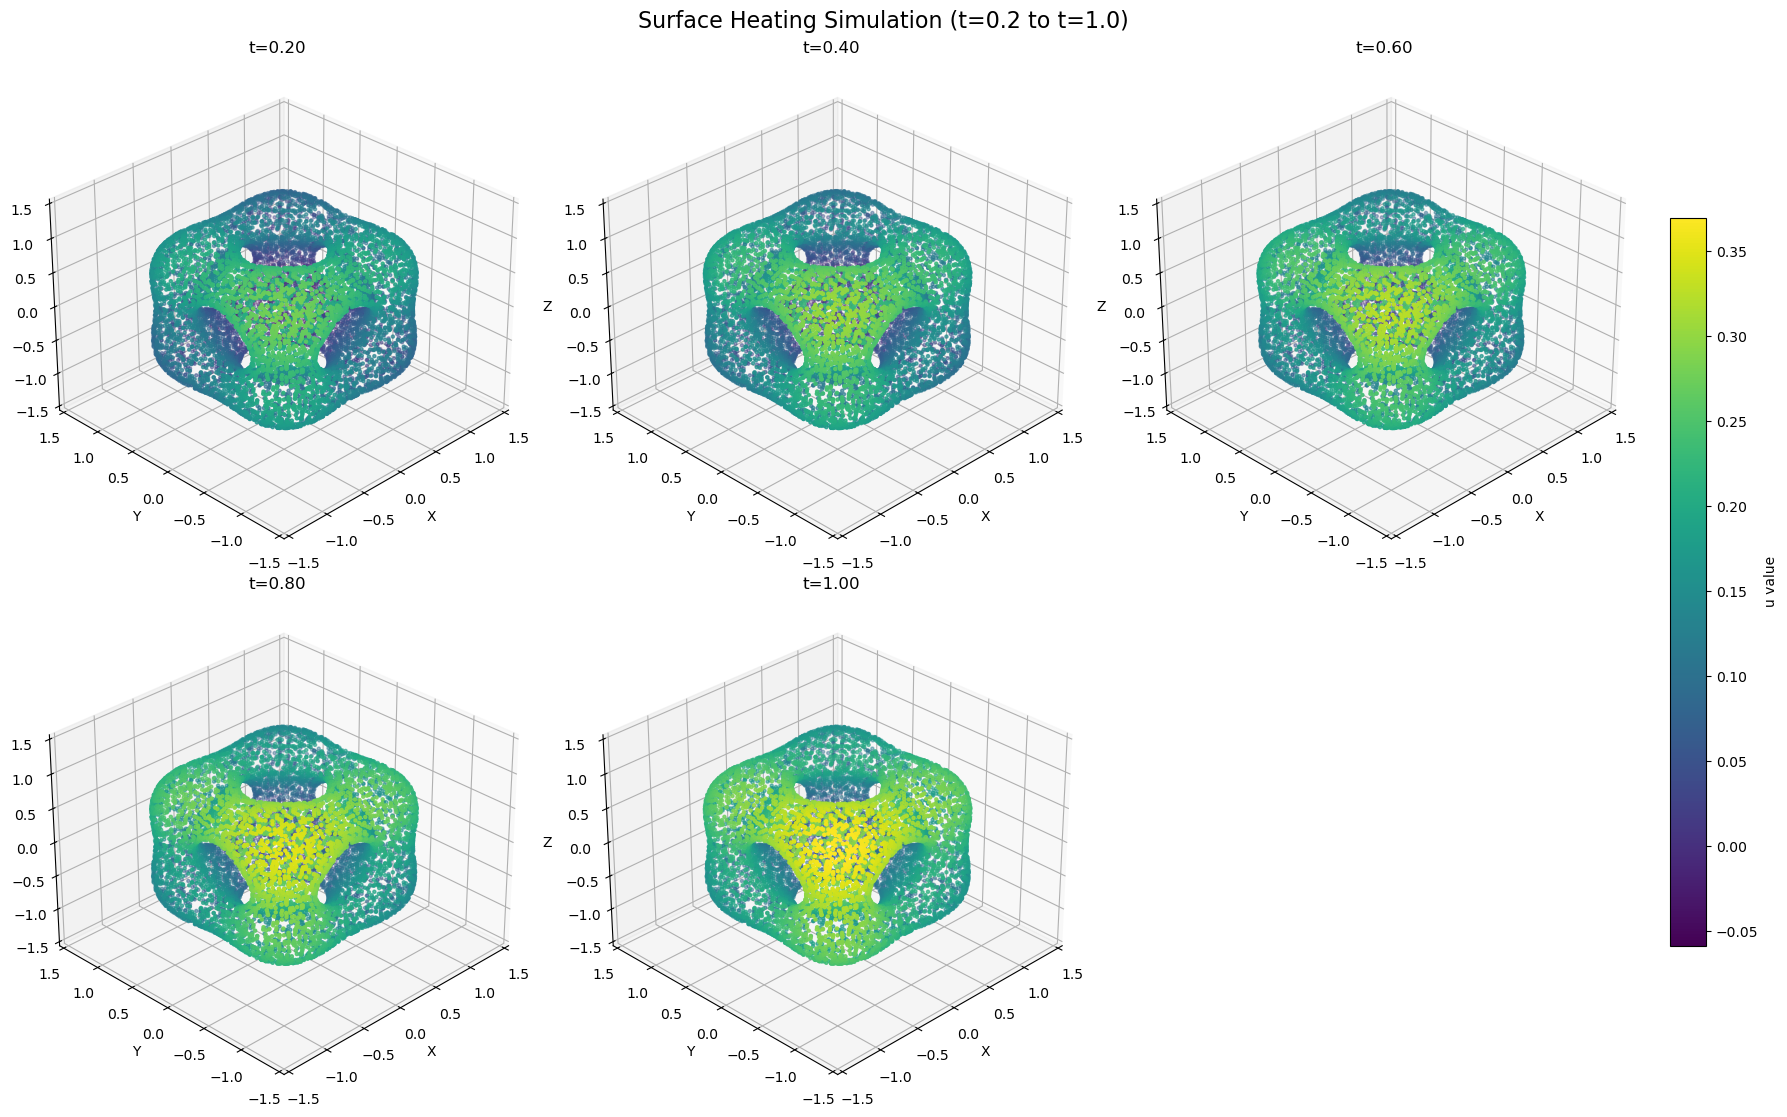

In [54]:
# --- 9. Visualization (MODIFIED FOR HIGH-RES, 2x3 GRID, CONSTRAINED LAYOUT) ---

# Plotting function remains the same as previous version (accepts ax)
def plot_surface_data(ax, points, data, t, vmin=None, vmax=None, cmap='viridis', title_suffix=""):
    """Plots surface data on a given matplotlib axis."""
    if points is None or points.shape[0] == 0: # MODIFIED Check
        print(f"No points to plot for t={t:.2f}")
        ax.set_title(f"t={t:.2f} (No data)")
        ax.axis('off')
        return
    ax.cla() # Clear axis before plotting new data
    sc = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=data, cmap=cmap, vmin=vmin, vmax=vmax, s=5) # Smaller points s=5
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    ax.set_title(f"t={t:.2f}{title_suffix}")
    ax.view_init(elev=30., azim=225)
    ax.set_xlim(bbox[0]); ax.set_ylim(bbox[1]); ax.set_zlim(bbox[2])
    # Return scatter object for colorbar creation
    return sc

print("\nGenerating high-resolution points for plotting...")
# MODIFIED: Generate high-resolution points once
plot_points_hr = generate_surface_points_marching_cubes(10000, grid_points_per_dim=100)
if plot_points_hr is None or plot_points_hr.shape[0] == 0:
    print("Failed to generate high-resolution points. Skipping high-res plotting.")
    # Optionally fall back to low-res plotting or exit
    exit()

print("\nPlotting results using high-resolution points...")

# Determine global color range requires evaluating networks on high-res points
# This might be slow. Alternatively, use range from low-res results.
# Let's use low-res range for efficiency first.
all_u_values_low_res = np.concatenate([u for u in results_u if u.size > 0])
if all_u_values_low_res.size > 0:
    vmin, vmax = np.min(all_u_values_low_res), np.max(all_u_values_low_res)
    print(f"Approximate Solution range [min, max]: [{vmin:.4f}, {vmax:.4f}] (from low-res data)")
else:
    vmin, vmax = 0, 0.1
    print("No valid solution values found.")

# Define target times to plot
plot_interval = 0.2
target_plot_times = np.arange(0.2, T_final + 1e-9, plot_interval)
print(f"Target plot times: {target_plot_times}")

# --- Create Figure and Subplots ---
num_plots = len(target_plot_times)
if num_plots > 6:
    print(f"Warning: More than 6 target plot times ({num_plots}). Plotting only the first 6.")
    num_plots = 6
    target_plot_times = target_plot_times[:6]

# MODIFIED: Use constrained_layout=True
fig, axs = plt.subplots(2, 3, figsize=(18, 11), subplot_kw={'projection': '3d'}, constrained_layout=True) # Increased height slightly
axs = axs.ravel()

plot_idx = 0
plotted_indices = set()
time_tolerance = dt / 2.0
scatter_object_for_colorbar = None # Store one scatter object

# Loop through target times and plot using high-res points
for target_t in target_plot_times:
    if plot_idx >= len(axs): break

    best_match_idx = -1; min_diff = float('inf')
    for i in range(len(results_time)): # Find corresponding index in results
        diff = abs(results_time[i] - target_t)
        if diff < min_diff and diff < time_tolerance: min_diff = diff; best_match_idx = i

    if best_match_idx != -1 and best_match_idx not in plotted_indices:
        current_ax = axs[plot_idx]
        current_time_actual = results_time[best_match_idx]
        print(f"Processing frame {plot_idx+1}/6 for t ~ {target_t:.2f} (actual t = {current_time_actual:.2f})")

        # MODIFIED: Evaluate network on high-res points
        if best_match_idx == 0: # Initial condition
            u_data_hr = np.zeros(plot_points_hr.shape[0])
        else:
            # Load state dict (index is best_match_idx - 1 as results has t=0 but states start after step 1)
            if (best_match_idx - 1) < len(all_net_state_dicts):
                state_dict_to_load = all_net_state_dicts[best_match_idx - 1]
                plot_net = ShallowMultiOutputNet(N_neurons, q + 1).to(device) # Create net on correct device
                # Ensure state dict keys match (might need to load to CPU first if saved on CPU)
                plot_net.load_state_dict({k: v.to(device) for k, v in state_dict_to_load.items()}) # Load to device
                plot_net.eval()
                with torch.no_grad():
                    u_data_hr = plot_net(plot_points_hr)[:, -1].cpu().numpy()
            else:
                print(f"Error: State dictionary not found for index {best_match_idx - 1}")
                u_data_hr = np.full(plot_points_hr.shape[0], np.nan) # Plot NaNs if state missing

        # Call plotting function with high-res data
        sc_object = plot_surface_data(current_ax,
                                      plot_points_hr.cpu().numpy(), # Ensure points are numpy on CPU
                                      u_data_hr,
                                      current_time_actual,
                                      vmin=vmin, vmax=vmax)
        if sc_object: scatter_object_for_colorbar = sc_object # Store scatter object for colorbar

        plotted_indices.add(best_match_idx)
        plot_idx += 1

# Hide unused subplots
for i in range(plot_idx, len(axs)):
    axs[i].axis('off')

# Add a single colorbar
if scatter_object_for_colorbar:
    try:
        # Use the last scatter object created
        fig.colorbar(scatter_object_for_colorbar, ax=axs.tolist(), shrink=0.7, pad=0.02, label="u value") # Adjust pad
    except Exception as e:
        print(f"Could not create figure colorbar: {e}")
else:
    print("No frames plotted or scatter object not found, skipping colorbar.")

# Add a main title
fig.suptitle("Surface Heating Simulation (t=0.2 to t=1.0)", fontsize=16)

# REMOVED: plt.tight_layout(...) - Use constrained_layout instead

# Show the figure
plt.show()